<a href="https://colab.research.google.com/github/KLeeDE/PUS2020_KLee/blob/master/HW9/Image/20201127_Wilimington_oneper_blockg_sjoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SPPA667 HW9: Plots and Visualization**

Written by: @KLeeDE

Date: 11/10/2020

**Topic**: An Analysis on Flood Risk and Socio-Economic and Demographic Status

**Research Area**: Wilmington, Delaware


**Available data**

Wilmington data

1. Flood Depth Grid (2014/Raster/Federal Emergency Management Agency (FEMA)
*  CstDpthxxxpct: Coastal flood depth for the xxx percent
annual chance flood event. This raster is
required to be produced for coastal Flood
Risk Projects. [Feet]
*   CstDpth_01pct : Raster dataset of flood depth for a coastal 1% event. (1-percent-annualchance) [Feet]
*   Depth_01pct : Raster dataset of flood depth for a 1% event [Feet]

2. Census data Block Group (2010/CSV/U.S.Census Bureau)

3. Socioeconomic and Demographic (SED) data (2014 (ACS5) / Shapefile / U.S. Census Bureau)




**Additional rastar data description**

County
*   10001C: Kent County
*   10003C: New Castle County
*   10005C: Sussex County

Flood hazard is defined by a relation between depth of flooding and the annual chance of inundation greater than that depth.

Depth grid is defined by **the percent annual chance floods**. This is usually only **the 1% annual chance flood**.

# Original Plot

In [ ]:
# -- mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# -- install geospatial packages
!sudo apt install libspatialindex-dev
!pip install rtree
!pip install geopandas
!pip install censusdata

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (719 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.

In [ ]:
import time
import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdal
from gdalconst import *
from shapely.geometry import Point
from collections import Counter
import censusdata

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

## Flood Depth data

In [ ]:
# data: 1% depth / DE / coastal area / New Castle (10003C)
fname3C_Cst_Dpth01pct = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/New  Castle/FRD_10003C_Coastal_GeoTIFFS_20140516/10003C_Coastal_CstDpth01pct.tif"
# read in a raster data
rast3C_Cst_Dpth01pct = gdal.Open(fname3C_Cst_Dpth01pct, GA_ReadOnly)
# extract raster to array
samp=100
arr3C_Cst_Dpth01pct = rast3C_Cst_Dpth01pct.ReadAsArray()[::samp, ::samp]
arr3C_Cst_Dpth01pct = arr3C_Cst_Dpth01pct.clip(0,10)
#arr3C_Cst_Dpth01pct = rast3C_Cst_Dpth01pct.ReadAsArray()

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:488: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


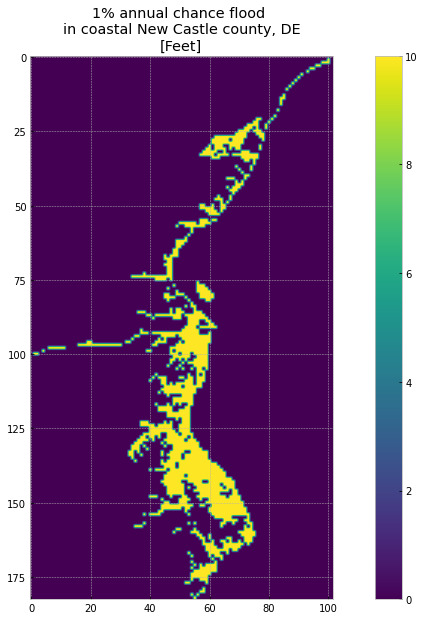

In [ ]:
#  plot raster : 1% depth / DE / coastal area  
fig_raster, ax = plt.subplots()
im = ax.imshow(arr3C_Cst_Dpth01pct)

ax.imshow(rast3C_Cst_Dpth01pct.ReadAsArray()[::samp, ::samp])
ax.set_title("1% annual chance flood \nin coastal New Castle county, DE\n[Feet]")
fig_raster.colorbar(im)
plt.show()

**Fig1. Flood Depth Grid** Subtitle is the one percent annual chance flood in coastal New Castle County (Unit: Feet). Flood hazard is defined by a relation between depth of flooding and the annual chance of inundation greater than that depth. Depth grid is defined by the percent annual chance floods. This is usually only the 1% annual chance flood.This figure is  based on the raster data from the Federal Emergency Management Agency (FEMA) in 2014, which is the most recent available data in Delaware. 

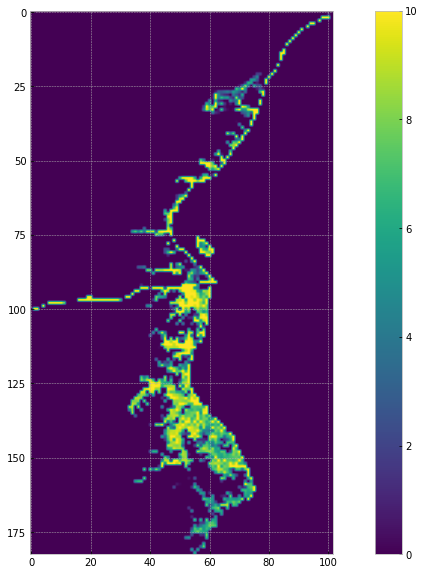

In [ ]:
 # set Latitude/Longitude

# read in the meta data file as list of strings:
mname3c = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/New  Castle/FRD_10003C_Coastal_GeoTIFFS_20140516/10003C_Coastal_CstDpth01pct.tif.xml"
fopen = open(mname3c, "r")
lines = [i for i in fopen]
fopen.close()

# get lat lon meta data
for line in lines:
  if "<westBL Sync=\"TRUE\">" in line:
    westBL = float(line.split("<westBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<eastBL Sync=\"TRUE\">" in line:
    eastBL = float(line.split("<eastBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<northBL Sync=\"TRUE\">" in line:
    northBL = float(line.split("<northBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<southBL Sync=\"TRUE\">" in line:
    southBL = float(line.split("<southBL Sync=\"TRUE\">")[2].split("<")[0])

# get number of rows and cols
nrows3c, ncols3c = arr3C_Cst_Dpth01pct.shape

# create lat and lon arrays
# define upperleft and resolution
ul_r = northBL
ul_c = westBL
dr   = (northBL - southBL) / nrows3c
dc   = (eastBL - westBL) / ncols3c

# generate a grid of row and col indices
cols3c, rows3c = np.meshgrid(np.arange(ncols3c), np.arange(nrows3c))

lat_grid_3c = ul_r - rows3c * dr
lon_grid_3c = ul_c + cols3c * dc

# plt.imshow(lat_grid_3c)
# plt.colorbar()
# plt.hist(np.log10(arr1C_Cst_Dpth01pct[arr1C_Cst_Dpth01pct > 0]))

dep_grid_3c = arr3C_Cst_Dpth01pct
ax = plt.imshow(dep_grid_3c)
plt.colorbar()

# plt.hist(dep_grid_3c[dep_grid_3c > -1e38].flatten())

## Block Group shapefile

In [ ]:
def label_plot(plot_axis, title, x_axis_label, y_axis_label, title_weight="bold", title_size=16, axis_weight="bold", axis_size=14 ):
  plot_axis.set_title(title, weight=title_weight, size=title_size)
  plot_axis.set_xlabel(x_axis_label, weight=axis_weight, size=axis_size)
  plot_axis.set_ylabel(y_axis_label, weight=axis_weight, size=axis_size)

In [ ]:
# load the census block group (2010)
cblkname = "/content/drive/My Drive/flooding/data/censusblock/Census_Block_Groups_2010/Census_Block_Groups_2010.shp"
decblkg_2010 = gp.read_file(cblkname)
decblkg_2010

,OBJECTID,COUNTYFP10,BLKGRPCE10,GEOID10,NAMELSAD10,POPULATION,HOUSING_UN,NAME10,geometry
0,8,001,3,100010432023,Block Group 3,976,571,432.02,"POLYGON ((-75.39664 39.05831, -75.39736 39.058..."
1,9,001,2,100010432022,Block Group 2,659,320,432.02,"POLYGON ((-75.39664 39.05831, -75.39563 39.058..."
2,10,001,4,100010432024,Block Group 4,1000,433,432.02,"POLYGON ((-75.35792 39.03170, -75.35241 39.036..."
3,11,001,1,100010405021,Block Group 1,713,300,405.02,"POLYGON ((-75.52454 39.22149, -75.52682 39.219..."
4,12,001,2,100010405022,Block Group 2,1268,611,405.02,"POLYGON ((-75.52036 39.18897, -75.52192 39.190..."
...,...,...,...,...,...,...,...,...,...
566,538,003,4,100030135014,Block Group 4,2647,1187,135.01,"POLYGON ((-75.64042 39.77548, -75.64046 39.775..."
567,539,003,1,100030135011,Block Group 1,1328,466,135.01,"POLYGON ((-75.69650 39.80558, -75.69638 39.805..."
568,540,003,3,100030135013,Block Group 3,1591,571,135.01,"POLYGON ((-75.63990 39.76219, -75.64013 39.761..."
569,541,003,2,100030135012,Block Group 2,1036,357,135.01,"POLYGON ((-75.64041 39.76148, -75.64023 39.761..."


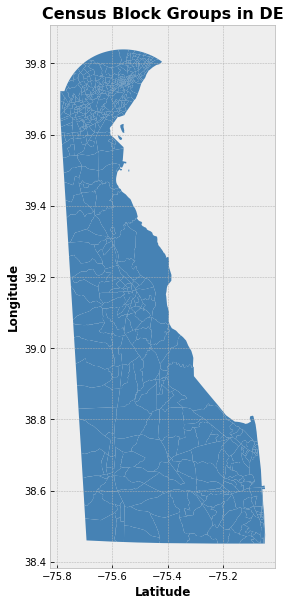

In [ ]:
# figure
fig_cblockg, ax = plt.subplots()
decblkg_2010.plot(color="steelblue", ax=ax)
label_plot(ax, "Census Block Groups in DE", "Latitude", "Longitude", axis_size=12, title_size=16)
fig_cblockg.savefig("/content/drive/My Drive/flooding/figure/sppa667")

**Fig 2. Census Block Groups** Subtitle is the census block groups in New Castle County. This figure is based on 2010 shapefile. Please note that the most recent data is 2016 but this figure is based on 2010 data to align with the other available data in this research. 

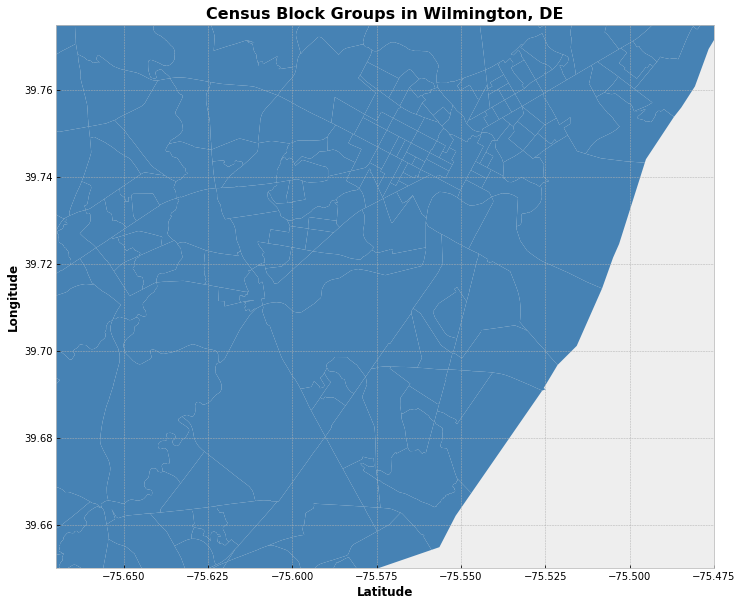

In [ ]:
decblkg_2010_copy = decblkg_2010.copy()

fig_cblockg_wm, ax = plt.subplots()
decblkg_2010_copy.plot(color="steelblue", ax=ax)
ax.set_xlim(-75.67, -75.475)
ax.set_ylim(39.65, 39.775)
label_plot(ax, "Census Block Groups in Wilmington, DE", "Latitude", "Longitude", axis_size=12, title_size=16)

fig_cblockg_wm.savefig("/content/drive/My Drive/flooding/figure/sppa667")

## Socioeconomic demographic (SED) data 

In [ ]:
# -- lablel plot
def label_plot(plot_axis, title, x_axis_label, y_axis_label, title_weight="bold", title_size=16, axis_weight="bold", axis_size=14 ):
  plot_axis.set_title(title, weight=title_weight, size=title_size)
  plot_axis.set_xlabel(x_axis_label, weight=axis_weight, size=axis_size)
  plot_axis.set_ylabel(y_axis_label, weight=axis_weight, size=axis_size)

#--Getting standardized values
def standardize(dataframe, original_column_name:str, intended_column_name:str):
  values = dataframe[original_column_name]
  values_mean = values.mean()
  values_stdev = values.std()
  standardized_values = []
  for i in values:
    standardized_values.append((i-values_mean)/values_stdev)
  dataframe[intended_column_name] = standardized_values

In [ ]:
# -- Median household income by census block group : New Castle
censusdata.censustable('acs5', 2014, 'B19049')
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
income_cblkg = censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '003'), ('block group', '*')]), ["B19049_001E"])
nc_income_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B19049_001E"]) for i in ["003"]])
nc_income_cblkg['mincome'] = nc_income_cblkg["B19049_001E"].clip(0,1e9).dropna() 
#--Getting standardized values
standardize(nc_income_cblkg, "mincome", "mincome_st")
nc_income_cblkg = nc_income_cblkg[["mincome", "mincome_st"]]
#--data description
print("Median household income in New Castle County, DE")
print(nc_income_cblkg.describe())

Median household income in New Castle County, DE
             mincome    mincome_st
count     368.000000  3.680000e+02
mean    67356.024457 -3.891814e-17
std     33026.081728  1.000000e+00
min         0.000000 -2.039480e+00
25%     45678.750000 -6.563683e-01
50%     61144.000000 -1.880945e-01
75%     83391.000000  4.855246e-01
max    209250.000000  4.296422e+00


In [ ]:
# -- Racial factors (White alone / Total) by census block group
censusdata.censustable('acs5', 2014, 'B02001')
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
race_cblkg = censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '003'), ('block group', '*')]), ["B02001_001E", "B02001_002E"])
nc_race_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B02001_001E", "B02001_002E"]) for i in ["003"]])
nc_race_cblkg['per_white'] = nc_race_cblkg["B02001_002E"] / nc_race_cblkg["B02001_001E"] * 100
nc_race_cblkg['per_nonwhite'] = (nc_race_cblkg["B02001_001E"] - nc_race_cblkg["B02001_002E"])/nc_race_cblkg["B02001_001E"] *100
nc_race_cblkg = nc_race_cblkg[['per_white', 'per_nonwhite']].clip(0,1e9).dropna()
#--Getting standardized values
standardize(nc_race_cblkg, "per_nonwhite", "per_nonwhite_st")
nc_race_cblkg = nc_race_cblkg[["per_nonwhite", "per_nonwhite_st"]]
#--data description
print("Percent of Not White in New Castle County, DE")
print(nc_race_cblkg.describe())

Percent of Not White in New Castle County, DE
       per_nonwhite  per_nonwhite_st
count    366.000000     3.660000e+02
mean      33.694627     9.591599e-16
std       27.510316     1.000000e+00
min        0.000000    -1.224800e+00
25%       11.243796    -8.160877e-01
50%       24.158250    -3.466473e-01
75%       50.777329     6.209562e-01
max      100.000000     2.410200e+00


In [ ]:
# Poverty rate by census block group
censusdata.censustable('acs5', 2014, 'B17010')
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
poverty_cblkg = censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '003'), ('block group', '*')]), ["B17010_001E", "B17010_002E"])
nc_poverty_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B17010_001E", "B17010_002E"]) for i in ["003"]])
nc_poverty_cblkg['per_below_povlev'] = nc_poverty_cblkg["B17010_002E"] / nc_poverty_cblkg["B17010_001E"] * 100
nc_poverty_cblkg = nc_poverty_cblkg[['per_below_povlev']].clip(0,1e9).dropna()
#--Getting standardized values
standardize(nc_poverty_cblkg, 'per_below_povlev', 'per_below_povlev_st')
nc_poverty_cblkg = nc_poverty_cblkg[["per_below_povlev", "per_below_povlev_st"]]
#--data description
print("Percent of People Under Poverty Line in New Castle County, DE")
print(nc_poverty_cblkg.describe())

Percent of People Under Poverty Line in New Castle County, DE
       per_below_povlev  per_below_povlev_st
count        365.000000         3.650000e+02
mean           9.214050         1.659631e-17
std           13.249521         1.000000e+00
min            0.000000        -6.954251e-01
25%            0.000000        -6.954251e-01
50%            3.773585        -4.106160e-01
75%           12.932790         2.806698e-01
max           82.666667         5.543794e+00


In [ ]:
# -- Income Data : New Castle
# -- initialize GEOID container
geoids = []
# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in nc_income_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
# -- set GEOID column in income DataFrame
nc_income_cblkg["cblockgid"] = geoids

# -- initialize GEOID container
geoids = []
# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in nc_race_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
# -- set GEOID column in income DataFrame
nc_race_cblkg["cblockgid"] = geoids


# -- Poverty Data : New Castle
# -- initialize GEOID container
geoids = []
# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in nc_poverty_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
# -- set GEOID column in income DataFrame
nc_poverty_cblkg["cblockgid"] = geoids

In [ ]:
# Merging with census tract geodataframe
nc_demo = nc_income_cblkg.merge(nc_race_cblkg, how="outer", left_on="cblockgid", right_on="cblockgid").merge(nc_poverty_cblkg, how="outer", left_on="cblockgid", right_on="cblockgid")
nc_demo = nc_demo[["cblockgid", "mincome", "mincome_st", "per_nonwhite", "per_nonwhite_st", "per_below_povlev", "per_below_povlev_st"]]

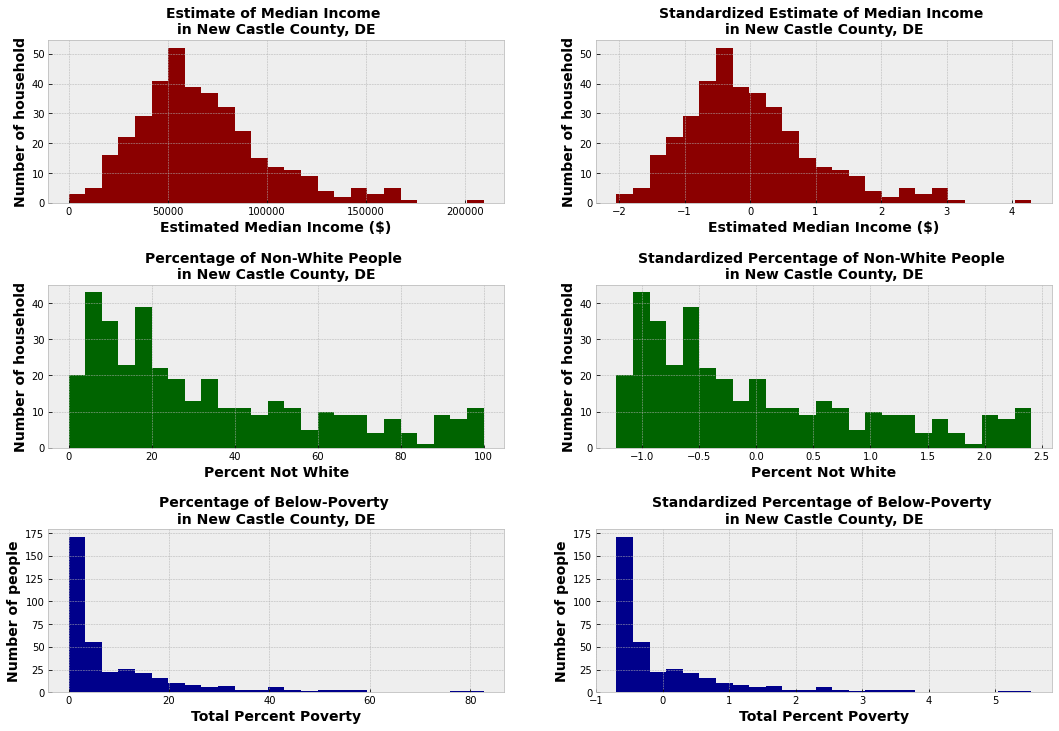

In [ ]:
# Figure
fig_nc_demo, ax=plt.subplots(nrows=3, ncols=2, figsize=[18, 12])
plot1 = ax[0,0]
plot2 = ax[0,1]
plot3 = ax[1,0]
plot4 = ax[1,1]
plot5 = ax[2,0]
plot6 = ax[2,1]


nc_demo.hist('mincome', ax=plot1, bins=25, color="darkred")
label_plot(plot1, "Estimate of Median Income \nin New Castle County, DE", "Estimated Median Income ($)", "Number of household", axis_size=14, title_size=14)
nc_demo.hist('mincome_st', ax=plot2, bins=25, color="darkred")
label_plot(plot2, "Standardized Estimate of Median Income \nin New Castle County, DE", "Estimated Median Income ($)", "Number of household", title_size=14, axis_size=14)

nc_demo.hist('per_nonwhite', ax=plot3, bins=25, color="darkgreen")
label_plot(plot3, "Percentage of Non-White People \nin New Castle County, DE", "Percent Not White", "Number of household", axis_size=14, title_size=14)
nc_demo.hist('per_nonwhite_st', ax=plot4, bins=25, color="darkgreen")
label_plot(plot4, "Standardized Percentage of Non-White People \nin New Castle County, DE", "Percent Not White", "Number of household", title_size=14, axis_size=14)

nc_demo.hist('per_below_povlev', ax=plot5, bins=25, color="darkblue")
label_plot(plot5, "Percentage of Below-Poverty \nin New Castle County, DE", "Total Percent Poverty", "Number of people", axis_size=14, title_size=14)
nc_demo.hist('per_below_povlev_st', ax=plot6, bins=25, color="darkblue")
label_plot(plot6, "Standardized Percentage of Below-Poverty \nin New Castle County, DE", "Total Percent Poverty", "Number of people", title_size=14, axis_size=14)

fig_nc_demo.subplots_adjust(wspace=.2, hspace=.5)
fig_nc_demo.show()

**Fig 3 Socioeconomic demographic (SED) status** Subtitle is the socioeconomic demographic status in New Castle County. The data is estimated from 2014 to 2018 and the data source is from the U.S. Census Bureau. In this figure, the mean of the median household income is $6,7356, the mean of the percentage of not white people is 33.7%, and the rate of the total percentage of poverty is 9.2%.   

# Geocoding: Raster data to Census block group shapefile, Shapefile to SES data


## Set GEOID & Merge dataframe

In [ ]:
# income
geoids = []
for cgeo in nc_income_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
nc_income_cblkg["cblockgid"] = geoids

# race 
geoids = []
for cgeo in nc_race_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
nc_race_cblkg["cblockgid"] = geoids

# poverty
geoids = []
for cgeo in nc_poverty_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
nc_poverty_cblkg["cblockgid"] = geoids

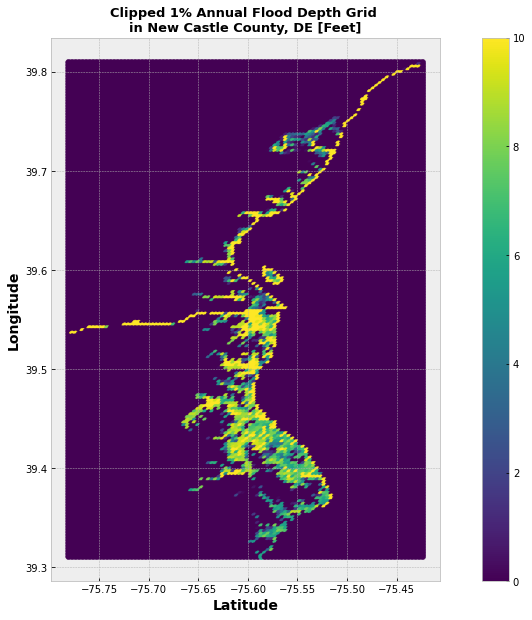

In [ ]:
# Raster data preprocessing 
df_dgrid_3c = pd.DataFrame(columns=["lat", "lon", "dep"])
#dep_grid_3c = arr3C_Cst_Dpth01pct
df_dgrid_3c["lat"] = lat_grid_3c.flatten()
df_dgrid_3c["lon"] = lon_grid_3c.flatten()
df_dgrid_3c["dep"] = dep_grid_3c.flatten().astype(float)
def make_point(x):
  return Point(x["lon"], x["lat"])
  make_point(df_dgrid.iloc[0])
df_dgrid_3c["geometry"] = df_dgrid_3c.apply(make_point, axis=1)
df_dgrid = df_dgrid_3c
df_dgrid

df_dgrid_3c = gp.GeoDataFrame(df_dgrid_3c)
df_dgrid = gp.GeoDataFrame(df_dgrid)

#Figure
fig_df_dgrid, ax = plt.subplots()
df_dgrid.plot("dep", ax=ax, legend=True)
label_plot(ax, "Clipped 1% Annual Flood Depth Grid \nin New Castle County, DE [Feet]", "Latitude", "Longitude", axis_size=14, title_size=13)

fig_df_dgrid.savefig("/content/drive/My Drive/flooding/figure/sppa667")

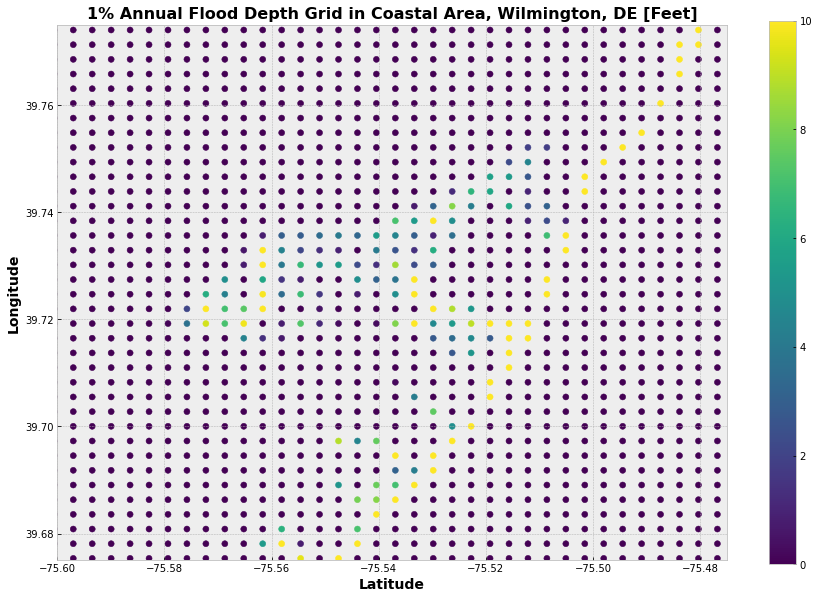

In [ ]:
# Wilmington figure
df_dgrid_copy = df_dgrid.copy()

fig_df_dgrid_wm, ax = plt.subplots()
df_dgrid_copy.plot("dep", ax=ax, legend=True)
ax.set_xlim(-75.6, -75.475)
ax.set_ylim(39.675, 39.775)
label_plot(ax, "1% Annual Flood Depth Grid in Coastal Area, Wilmington, DE [Feet]", "Latitude", "Longitude", axis_size=14, title_size=16)

fig_df_dgrid_wm.savefig("/content/drive/My Drive/flooding/figure/sppa667")

**Fig 4. Flood Depth Grid with Latitude and Longitude** Subtitle is the 1% Annual Flood Depth Grid in Coastal Area, Wilmington, Delaware (Unit:Feet). The data is based on the 2014 raster data from the FEMA. The figure above shows the 1% annual flood depth grid clipped from 0 to 1. The figure shows that the local area surrounded by the Delaware River has the flood risk. 


## Geospatial join raster data to census  shapefile

In [ ]:
# Perform a spatial join between the Raster data and Census block shape file
df_dgrid_3c_decblkg_2010 = gp.sjoin(df_dgrid_3c, decblkg_2010)
df_dgrid_decblkg_2010 = df_dgrid_3c_decblkg_2010

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  


In [ ]:
# get the average number of depth 
df_dgrid_3c_decblkg_2010["dep_cl"] = df_dgrid_3c_decblkg_2010["dep"].clip(0, 1e6)
df_dgrid_g = df_dgrid_3c_decblkg_2010.groupby("GEOID10").mean().reset_index()
cols = ["GEOID10", "lat", "lon", "dep", "dep_cl"]
df_dgrid_sub = df_dgrid_g[cols]

df_dgrid_sub = df_dgrid_sub[df_dgrid_sub["dep_cl"] > 0]

# Merge 
decblkg_2010_df_dgrid_merge = decblkg_2010.merge(df_dgrid_sub, on="GEOID10")
cols = ["GEOID10", "lat", "lon", "dep", "dep_cl", "geometry"]
decblkg_2010_df_dgrid_merge_cols = decblkg_2010_df_dgrid_merge[cols]

In [ ]:
df_dgrid_sub

,GEOID10,lat,lon,dep,dep_cl
44,100030019021,39.715852,-75.527069,3.203390,3.203390
45,100030019022,39.730521,-75.551046,2.406667,2.406667
64,100030027001,39.736320,-75.559004,2.162500,2.162500
68,100030029001,39.736383,-75.534006,4.000000,4.000000
69,100030029002,39.736549,-75.546331,2.466667,2.466667
74,100030030023,39.741800,-75.530268,2.275000,2.275000
76,100030101041,39.798741,-75.446935,1.745312,1.745312
87,100030105021,39.771888,-75.490107,0.769231,0.769231
90,100030105024,39.765867,-75.484085,1.666667,1.666667
91,100030105025,39.781468,-75.478062,1.818182,1.818182


In [ ]:
type(df_dgrid_sub)

pandas.core.frame.DataFrame

## Merge -> Sjoin

In [ ]:
# -- Let's convert the pandas.DataFrame into a geopandas.GeoDataFrame
#https://gis.stackexchange.com/questions/174159/convert-a-pandas-dataframe-to-a-geodataframe

from geopandas import GeoDataFrame

In [ ]:
type(df_dgrid_sub)

pandas.core.frame.DataFrame

In [ ]:
df_dgrid_sub = GeoDataFrame(df_dgrid_sub)
type(df_dgrid_sub)

geopandas.geodataframe.GeoDataFrame

In [ ]:
decblkg_2010.columns

Index(['OBJECTID', 'COUNTYFP10', 'BLKGRPCE10', 'GEOID10', 'NAMELSAD10',
       'POPULATION', 'HOUSING_UN', 'NAME10', 'geometry'],
      dtype='object')

In [ ]:
df_dgrid_sub.columns

Index(['GEOID10', 'lat', 'lon', 'dep', 'dep_cl'], dtype='object')

In [ ]:
# set geometry in df_dgrid_sub
from shapely.geometry import Polygon
import geopandas as gpd

In [ ]:
df_dgrid_sub["geometry"] = geopandas.points_from_xy(df_dgrid_sub.lon, df_dgrid_sub.lat)
df_dgrid_sub

,GEOID10,lat,lon,dep,dep_cl,geometry
44,100030019021,39.715852,-75.527069,3.203390,3.203390,POINT (-75.52707 39.71585)
45,100030019022,39.730521,-75.551046,2.406667,2.406667,POINT (-75.55105 39.73052)
64,100030027001,39.736320,-75.559004,2.162500,2.162500,POINT (-75.55900 39.73632)
68,100030029001,39.736383,-75.534006,4.000000,4.000000,POINT (-75.53401 39.73638)
69,100030029002,39.736549,-75.546331,2.466667,2.466667,POINT (-75.54633 39.73655)
74,100030030023,39.741800,-75.530268,2.275000,2.275000,POINT (-75.53027 39.74180)
76,100030101041,39.798741,-75.446935,1.745312,1.745312,POINT (-75.44694 39.79874)
87,100030105021,39.771888,-75.490107,0.769231,0.769231,POINT (-75.49011 39.77189)
90,100030105024,39.765867,-75.484085,1.666667,1.666667,POINT (-75.48409 39.76587)
91,100030105025,39.781468,-75.478062,1.818182,1.818182,POINT (-75.47806 39.78147)


In [ ]:
decblkg_2010["geometry"] = geopandas.points_from_xy(df_dgrid_sub.lon, df_dgrid_sub.lat)
df_dgrid_sub

,OBJECTID,COUNTYFP10,BLKGRPCE10,GEOID10,NAMELSAD10,POPULATION,HOUSING_UN,NAME10,geometry
0,8,001,3,100010432023,Block Group 3,976,571,432.02,"POLYGON ((-75.39664 39.05831, -75.39736 39.058..."
1,9,001,2,100010432022,Block Group 2,659,320,432.02,"POLYGON ((-75.39664 39.05831, -75.39563 39.058..."
2,10,001,4,100010432024,Block Group 4,1000,433,432.02,"POLYGON ((-75.35792 39.03170, -75.35241 39.036..."
3,11,001,1,100010405021,Block Group 1,713,300,405.02,"POLYGON ((-75.52454 39.22149, -75.52682 39.219..."
4,12,001,2,100010405022,Block Group 2,1268,611,405.02,"POLYGON ((-75.52036 39.18897, -75.52192 39.190..."
...,...,...,...,...,...,...,...,...,...
566,538,003,4,100030135014,Block Group 4,2647,1187,135.01,"POLYGON ((-75.64042 39.77548, -75.64046 39.775..."
567,539,003,1,100030135011,Block Group 1,1328,466,135.01,"POLYGON ((-75.69650 39.80558, -75.69638 39.805..."
568,540,003,3,100030135013,Block Group 3,1591,571,135.01,"POLYGON ((-75.63990 39.76219, -75.64013 39.761..."
569,541,003,2,100030135012,Block Group 2,1036,357,135.01,"POLYGON ((-75.64041 39.76148, -75.64023 39.761..."


In [ ]:
#decblkg_2010_df_dgrid_sjoin = gp.sjoin(decblkg_2010, df_dgrid_sub)
gp.sjoin(decblkg_2010, df_dgrid_sub)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  


AttributeError: ignored

## Merge geodata to SED factors data 

In [ ]:
# New Castle
decblkg_2010_df_dgrid_merge_cols_nc_demo = decblkg_2010_df_dgrid_merge_cols.merge(nc_demo, left_on="GEOID10", right_on="cblockgid",how="left")
nc_data = decblkg_2010_df_dgrid_merge_cols_nc_demo
cols = ["cblockgid", "geometry", "lat", "lon", 
        "dep", "dep_cl",
        "mincome", "mincome_st", 
        "per_nonwhite", "per_nonwhite_st",  
        "per_below_povlev", "per_below_povlev_st"]
nc_data_sub = nc_data[cols]
nc_data_sub.columns = ["cblockgid", "geometry", "lat", "lon", 
                    "dep", "dep_cl", "mincome", "mincome_st", "per_nonwhite", "per_nonwhite_st", "per_below_povlev", "per_below_povlev_st"]
nc_data_sub = nc_data_sub.dropna()

# Making a single plot 


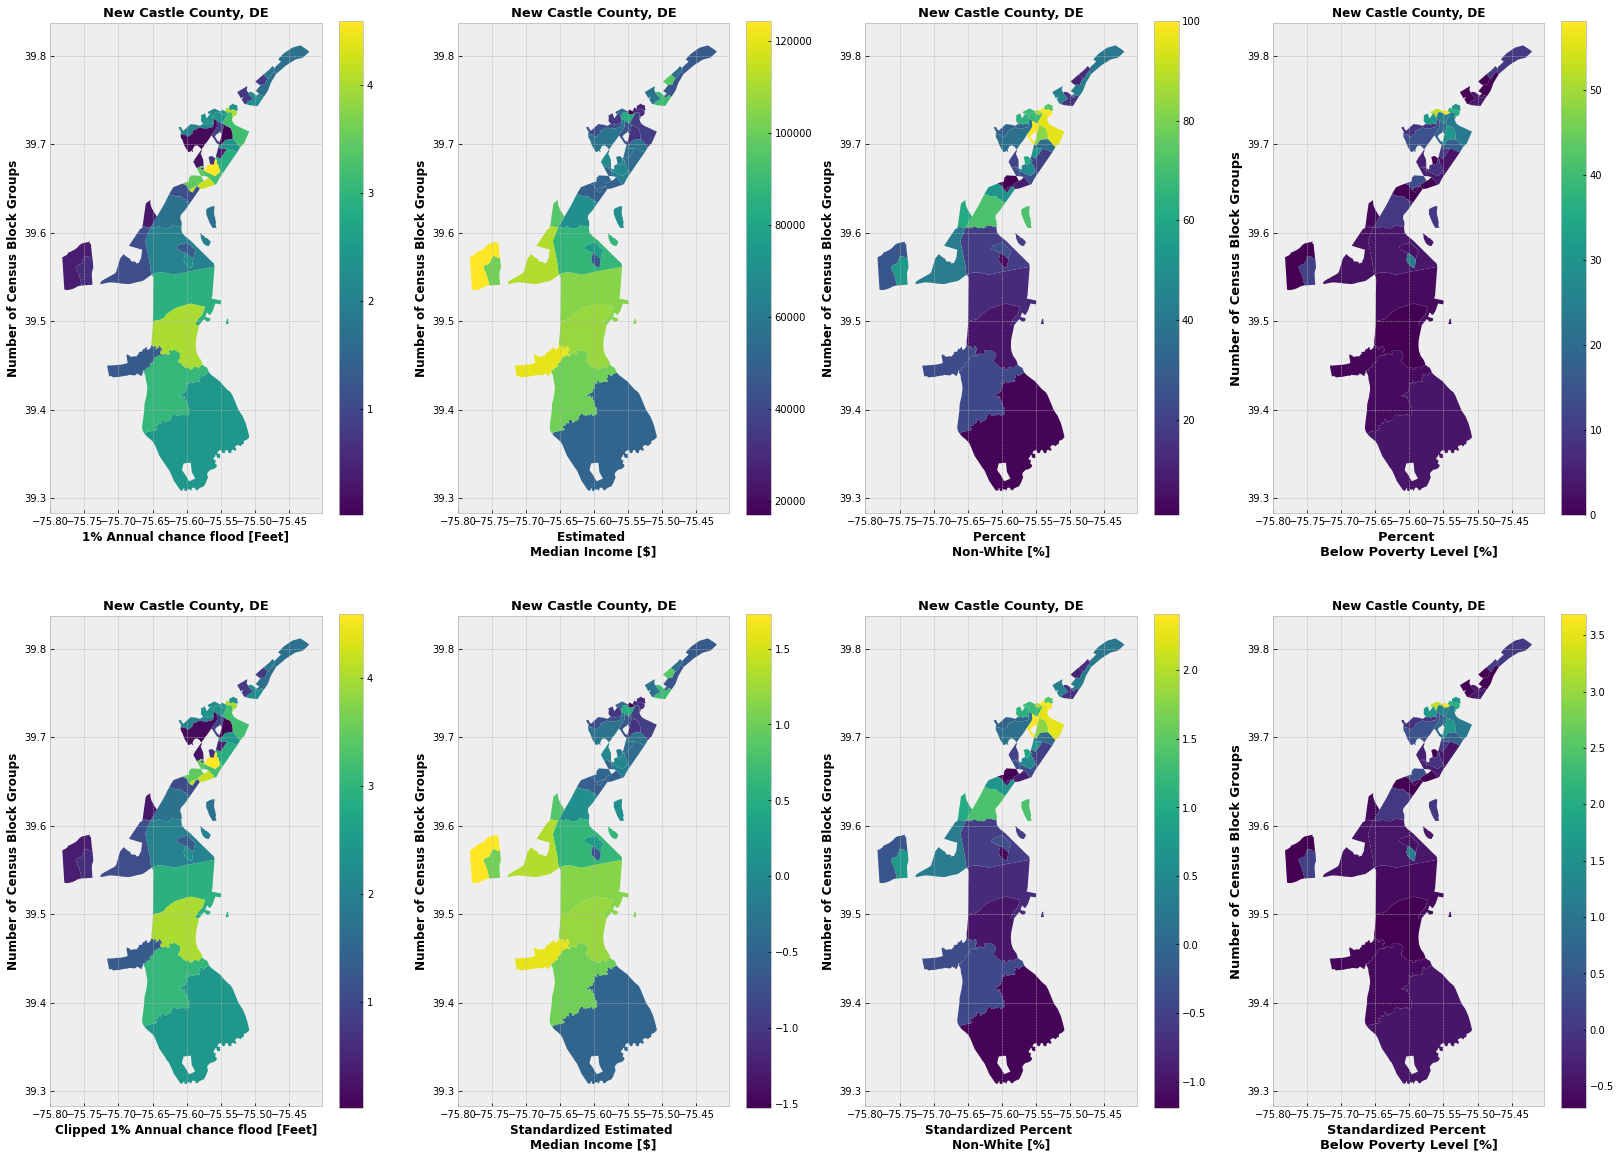

In [ ]:
# Plot
fig_nc_data_sub, ax=plt.subplots(nrows=2, ncols=4, figsize=[28, 20])
plot1 = ax[0,0]
plot2 = ax[0,1]
plot3 = ax[0,2]
plot4 = ax[0,3]
plot5 = ax[1,0]
plot6 = ax[1,1]
plot7 = ax[1,2]
plot8 = ax[1,3]

nc_data_sub.plot("dep", ax=plot1, legend=True)
label_plot(plot1, "New Castle County, DE", "1% Annual chance flood [Feet]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub.plot("mincome", ax=plot2, legend=True)
label_plot(plot2, "New Castle County, DE", "Estimated \nMedian Income [$]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub.plot("per_nonwhite", ax=plot3, legend=True)
label_plot(plot3, "New Castle County, DE", "Percent \nNon-White [%]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub.plot("per_below_povlev", ax=plot4, legend=True)
label_plot(plot4, "New Castle County, DE", "Percent \nBelow Poverty Level [%]", "Number of Census Block Groups", title_size=12, axis_size=13)

nc_data_sub.plot("dep_cl", ax=plot5, legend=True)
label_plot(plot5, "New Castle County, DE", "Clipped 1% Annual chance flood [Feet]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub.plot("mincome_st", ax=plot6, legend=True)
label_plot(plot6, "New Castle County, DE", "Standardized Estimated \nMedian Income [$]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub.plot("per_nonwhite_st", ax=plot7, legend=True)
label_plot(plot7, "New Castle County, DE", "Standardized Percent \nNon-White [%]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub.plot("per_below_povlev_st", ax=plot8, legend=True)
label_plot(plot8, "New Castle County, DE", "Standardized Percent \nBelow Poverty Level [%]", "Number of Census Block Groups", title_size=12, axis_size=13)

fig_nc_data_sub.show()
fig_nc_data_sub.savefig("/content/drive/My Drive/flooding/figure/sppa667")

In [ ]:
nc_data_sub_copy = nc_data_sub.copy()
nc_data_sub_copy.geometry.total_bounds

array([-75.782356,  39.307948, -75.420056,  39.811866])

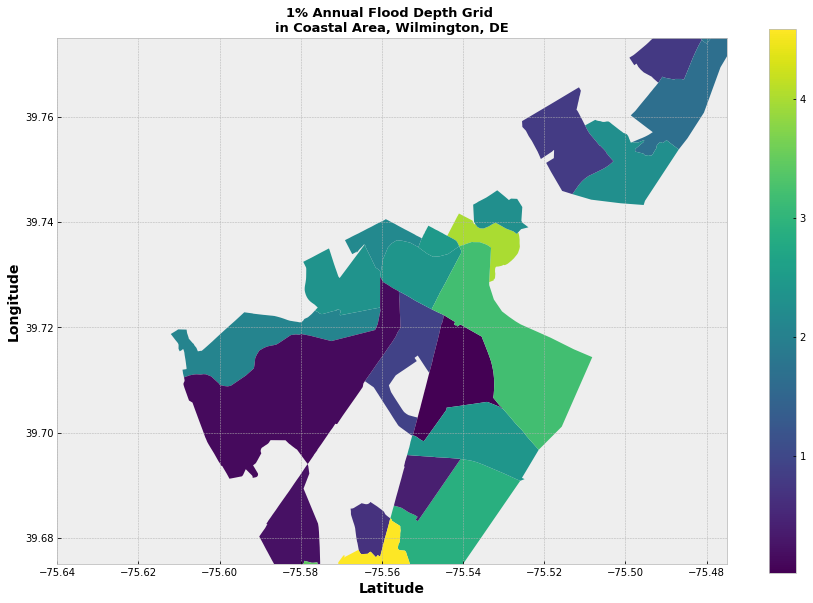

In [ ]:
ax = nc_data_sub_copy.plot("dep", legend=True)
ax.set_xlim(-75.64, -75.475)
ax.set_ylim(39.675, 39.775)
label_plot(ax, "1% Annual Flood Depth Grid \nin Coastal Area, Wilmington, DE", "Latitude", "Longitude", axis_size=14, title_size=13)

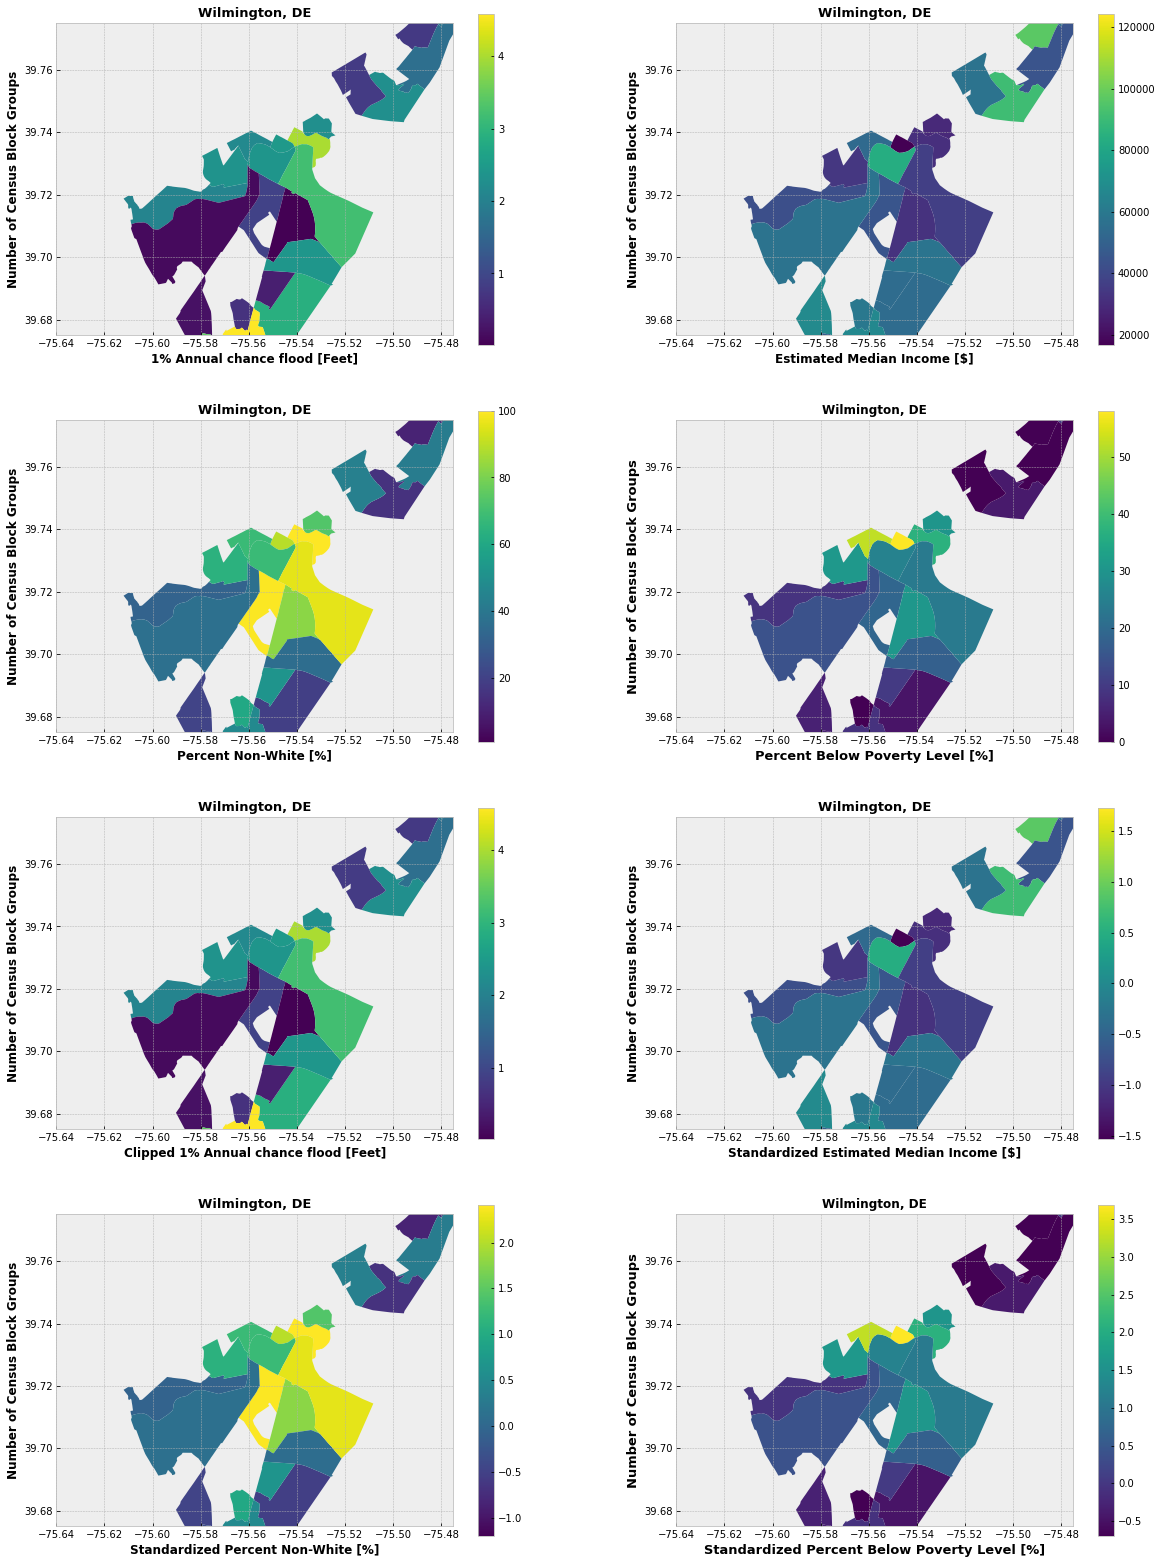

In [ ]:
# Plot
fig_nc_data_sub_wm, ax=plt.subplots(nrows=4, ncols=2, figsize=[20, 28])
plot1 = ax[0,0]
plot2 = ax[0,1]
plot3 = ax[1,0]
plot4 = ax[1,1]
plot5 = ax[2,0]
plot6 = ax[2,1]
plot7 = ax[3,0]
plot8 = ax[3,1]

nc_data_sub_copy.plot("dep", ax=plot1, legend=True)
plot1.set_xlim(-75.64, -75.475)
plot1.set_ylim(39.675, 39.775)
label_plot(plot1, "Wilmington, DE", "1% Annual chance flood [Feet]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub_copy.plot("mincome", ax=plot2, legend=True)
plot2.set_xlim(-75.64, -75.475)
plot2.set_ylim(39.675, 39.775)
label_plot(plot2, "Wilmington, DE", "Estimated Median Income [$]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub_copy.plot("per_nonwhite", ax=plot3, legend=True)
plot3.set_xlim(-75.64, -75.475)
plot3.set_ylim(39.675, 39.775)
label_plot(plot3, "Wilmington, DE", "Percent Non-White [%]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub_copy.plot("per_below_povlev", ax=plot4, legend=True)
plot4.set_xlim(-75.64, -75.475)
plot4.set_ylim(39.675, 39.775)
label_plot(plot4, "Wilmington, DE", "Percent Below Poverty Level [%]", "Number of Census Block Groups", title_size=12, axis_size=13)

nc_data_sub_copy.plot("dep_cl", ax=plot5, legend=True)
plot5.set_xlim(-75.64, -75.475)
plot5.set_ylim(39.675, 39.775)
label_plot(plot5, "Wilmington, DE", "Clipped 1% Annual chance flood [Feet]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub_copy.plot("mincome_st", ax=plot6, legend=True)
plot6.set_xlim(-75.64, -75.475)
plot6.set_ylim(39.675, 39.775)
label_plot(plot6, "Wilmington, DE", "Standardized Estimated Median Income [$]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub_copy.plot("per_nonwhite_st", ax=plot7, legend=True)
plot7.set_xlim(-75.64, -75.475)
plot7.set_ylim(39.675, 39.775)
label_plot(plot7, "Wilmington, DE", "Standardized Percent Non-White [%]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub_copy.plot("per_below_povlev_st", ax=plot8, legend=True)
plot8.set_xlim(-75.64, -75.475)
plot8.set_ylim(39.675, 39.775)
label_plot(plot8, "Wilmington, DE", "Standardized Percent Below Poverty Level [%]", "Number of Census Block Groups", title_size=12, axis_size=13)

fig_nc_data_sub_wm.subplots_adjust(wspace=.25)
fig_nc_data_sub_wm.show()

fig_nc_data_sub_wm.savefig("/content/drive/My Drive/flooding/figure/sppa667")

**Fig 5. Flood depth and SED results** Subtitle is the 1% Annual Flood Depth Grid and Socioeconomic Demographic Status in Coastal Area, Wilmington, Delaware. The figure above shows the urban area around the Delaware River in the city is exposed to the 1% annual flood risk. This area is surrounded by the minority who are under average medeian household income, not white, and below povert line. 

**Discussion and Conclusion** Through this project (homework 9), I found the area where the minority relatively lives more than the other area has more possibilities to expose to the flood risk. This issue can be related to the environmental justice, and therefore I look forward to make policy implications based on the data in terms of the data science and urban policy integration. However, this research still has the limitation in that the most recent data of the flood depth is based on 2014 and county level.


#Machine Learning

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

plt.style.use("bmh")

In [ ]:
nc_data_sub

,cblockgid,geometry,lat,lon,dep,dep_cl,mincome,mincome_st,per_nonwhite,per_nonwhite_st,per_below_povlev,per_below_povlev_st
0,100030148054,"POLYGON ((-75.73786 39.55819, -75.73791 39.558...",39.556520,-75.747618,0.614516,0.614516,101552,1.035423,54.197031,0.745262,10.990099,0.134046
1,100030148053,"POLYGON ((-75.75769 39.56399, -75.75833 39.563...",39.562996,-75.764462,0.373134,0.373134,124399,1.727210,27.499159,-0.225205,0.000000,-0.695425
2,100030166081,"MULTIPOLYGON (((-75.58552 39.51843, -75.58725 ...",39.532739,-75.603751,2.939379,2.939379,104712,1.131105,12.517849,-0.769776,1.663586,-0.569867
3,100030154001,"POLYGON ((-75.55189 39.72513, -75.55179 39.725...",39.715634,-75.554406,0.915000,0.915000,45417,-0.664294,99.479554,2.391282,18.918919,0.732469
4,100030129003,"POLYGON ((-75.57117 39.72338, -75.57084 39.723...",39.717569,-75.587961,2.078125,2.078125,42500,-0.752618,31.963087,-0.062941,8.517350,-0.052583
5,100030129001,"POLYGON ((-75.56046 39.72849, -75.56046 39.727...",39.728329,-75.569123,2.366667,2.366667,34074,-1.007750,64.350615,1.114345,31.058824,1.648722
7,100030029001,"POLYGON ((-75.53601 39.73890, -75.53582 39.738...",39.736383,-75.534006,4.000000,4.000000,31250,-1.093258,100.000000,2.410200,37.142857,2.107911
8,100030029002,"POLYGON ((-75.55090 39.73551, -75.55087 39.735...",39.736549,-75.546331,2.466667,2.466667,16875,-1.528520,89.269406,2.020143,58.064516,3.686961
9,100030169042,"POLYGON ((-75.61314 39.31320, -75.61440 39.314...",39.374911,-75.580075,2.462050,2.462050,51701,-0.474020,1.851852,-1.157485,3.333333,-0.443844
11,100030168041,"POLYGON ((-75.57671 39.45073, -75.57286 39.448...",39.422969,-75.628519,3.055533,3.055533,101220,1.025371,22.861128,-0.393798,1.603982,-0.574365


##1) Logistic Regression

Logistic Regression
* Objects: Census tracts (It can be changed to census blocks)
* Features:Estimated median income, Percent of population that is not white, Percent of people below the poverty line
* Target: Presence or absence of flood risk (Binary)


Model 1: All Features Included

* Objects: Census tracts

* Features: population density per square mile, square feet of residential area, square feet of commercial area, acres of park area, percent of the population under 18, percent of the population over 65, SES features (median income, percent of population below the poverty level, percent of children below the poverty level), and percent of the population that is not white

* Target: Presence or absense of a greenstreet

Model 2: Without Race and SES Features

* Objects: Census tracts

* Features: population density per square mile, square feet of residential area, square feet of commercial area, acres of park area, percent of the population under 18, and percent of the population over 65

* Target: Presence or absense of a greenstreet

##2) Random Forest Classifier

Random Forest Classifier
* Objects: Census tracts (It can be changed to census blocks) 
* Features:Estimated median income, Percent of population that is not white, Percent of people below the poverty line
* Target: Presence or absence of flood risk (Binary)


# Conclusion and Discussion

4.2.2 Green Streets Classification Analysis¶

Classification machine learning models were performed on the green streets data to determine how various features predicted whether or not a census had any green street area within its boundaries. The object and feature structures were similar for these models and the regression models in that the census tracts were the objects and the same features were used in all three models. For both classification models, the target was the presence or absense of green streets as recorded in the dataframe column "gst_present" using a 1 to represent the presence of green streets and a 0 to represent the absence of green streets. Census tracts with invalid values for any of the features and census tracts with under 1200 people were removed which allowed for the analysis of 2054 out of the original 2163 census tracts. However, only a total of 807 of these census tracts had green streets present, so the data set was balanced by creating a dataset consisting of the 807 census tracts with green streets present and 807 randomly selected census tracts from the 1247 census tracts without green streets. This final dataset, consisting of 1614 census tracts, was used for both the random forest classification and the logistic regression classification. To assess how the inclusion of race and SES features impacted the accuracy of model classification, the random forest classification and logistic regression were each performed twice - once with all features and once without race and SES features.

Random forest classification was performed using RandomForestClassifier from sklearn. The parameters for this model were tuned using GridSearch, and the accuracy of the model using the best parameters was calculated using the accuracy_score function from sklearn, which computes the proportion of predicted target values that were classified correctly. The feature importances given by the RandomForestClassifier model were recorded.

Logistic regression classification was performed using LogisticRegression from sklearn. The accuracy of the model was assessed using the accuracy_score function from sklearn to compute the proportion of target predictions by the model what were correctly classified according to the true target values. The coefficients for the logistic regression model were recorded and ranked in order of absolute value to determine the extent to which each feature contributed to the model.